In [5]:
# ============================
# Cell 1 — Imports & global settings
# ============================

# --- Standard library ---
import os
import sys
import time
import random

# --- Numerics / data handling ---
import numpy as np
import pandas as pd

# --- Progress / logging ---
from tqdm import tqdm

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- PIL (image IO) ---
from PIL import Image, ImageOps, UnidentifiedImageError, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # prevents crashes on partially saved images

# --- PyTorch core ---
import torch
import torch.nn as nn
import torch.optim as optim

# --- Torch utils ---
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# --- TorchVision (models + transforms) ---
from torchvision import models
import torchvision.transforms as transforms

# --- Scikit-learn (splits + metrics) ---
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve,
    auc
)

In [ ]:
# ============================
# Cell 2 — Configuration & Dataset Load
# ============================

# --- Reproducibility helper ---
def set_seed(seed=42):
    """
    Ensure reproducibility across NumPy, Python, and PyTorch.
    Forces deterministic CuDNN behavior (slower but reproducible).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --- Path to cleaned/preprocessed CSV ---
CSV_PATH = "data/calc_preprocessed_clean.csv"

# --- Load dataset ---
df = pd.read_csv(CSV_PATH)

# --- Ensure images exist ---
df = df[df["cropped_image_path"].apply(lambda x: isinstance(x, str) and os.path.exists(x))]
df = df.reset_index(drop=True)

# --- Normalize labels to integers (0=Benign, 1=Malignant) ---
if df["label"].dtype == object:
    label_map = {"Benign": 0, "Malignant": 1}
    df["label"] = df["label"].map(label_map).astype(int)
else:
    df["label"] = df["label"].astype(int)

# --- Report dataset stats ---
print(f"Loaded {len(df)} cropped images after file check.")
print("Class distribution:")
print(df["label"].value_counts())


Loaded 1609 cropped images after file check.
Class distribution:
label
0    1167
1     442
Name: count, dtype: int64


In [ ]:
# ============================
# Cell 3 — Train/Val/Test Split (stratified)
# ============================

random_state = 42  # ensures reproducibility of splits

# --- First split: Train (70%) and Temp (30%) ---
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,                # 30% reserved for val+test
    stratify=df["label"],         # stratified to preserve class balance
    random_state=random_state
)

# --- Second split: Validation (15%) and Test (15%) ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,                # 50% of temp → 15% of total
    stratify=temp_df["label"],    # maintain balance again
    random_state=random_state
)

# --- Reset indices for cleanliness ---
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

# --- Keep only required columns (slimmer, reproducible splits) ---
train_df = train_df[["cropped_image_path", "label"]].copy()
val_df   = val_df[["cropped_image_path", "label"]].copy()
test_df  = test_df[["cropped_image_path", "label"]].copy()

# --- Helper to print summary (class distribution in each split) ---
def _summary(name, dframe):
    counts = dframe["label"].value_counts().sort_index()
    total = len(dframe)
    benign = int(counts.get(0, 0))
    malignant = int(counts.get(1, 0))
    print(f"{name}: n={total} | "
          f"Benign: {benign} ({benign/total:.1%}) | "
          f"Malignant: {malignant} ({malignant/total:.1%})")

print("Stratified split complete.")
_summary("Train", train_df)
_summary("Val",   val_df)
_summary("Test",  test_df)


Stratified split complete.
Train: n=1126 | Benign: 817 (72.6%) | Malignant: 309 (27.4%)
Val: n=241 | Benign: 175 (72.6%) | Malignant: 66 (27.4%)
Test: n=242 | Benign: 175 (72.3%) | Malignant: 67 (27.7%)


In [ ]:
# ============================
# Cell 4 — Compute Mean/Std for Training Set
# ============================

def compute_mean_std(image_paths):
    """
    Compute the global mean and std for a list of grayscale images.

    Why?
    - Normalization using dataset-specific statistics (instead of ImageNet's)
      reduces domain shift and stabilizes training for medical images.
    - Calculated only on the training split to avoid data leakage.

    Args:
        image_paths (list[str]): list of image file paths.

    Returns:
        mean (float), std (float): scalar dataset-wide statistics in [0,1] space.
    """
    n_pixels = 0
    total_sum = 0.0
    total_sq_sum = 0.0

    for img_path in tqdm(image_paths, desc="Computing mean/std"):
        with Image.open(img_path).convert("L") as img:     # ensure grayscale & auto-close
            arr = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
        total_sum += arr.sum()
        total_sq_sum += (arr ** 2).sum()
        n_pixels += arr.size

    mean = total_sum / n_pixels
    std = np.sqrt(total_sq_sum / n_pixels - mean ** 2)
    return mean, std

# --- Compute stats on TRAIN split only (no leakage!) ---
train_image_paths = train_df["cropped_image_path"].tolist()
TRAIN_MEAN, TRAIN_STD = compute_mean_std(train_image_paths)

print(f"Training set mean: {TRAIN_MEAN:.4f}, std: {TRAIN_STD:.4f}")


Computing mean/std: 100%|██████████| 1126/1126 [00:06<00:00, 175.71it/s]

Training set mean: 0.4168, std: 0.2217


In [9]:
# ============================
# Cell 5 — Final Preprocessing Pipelines
# ============================

# NOTE: expects TRAIN_MEAN and TRAIN_STD to be defined from Cell 3a
# e.g., TRAIN_MEAN, TRAIN_STD = 0.4614, 0.2470

# --- Utility: pad image to square before resize (preserves aspect ratio) ---
def pad_to_square(img, fill=0):
    """
    Many crops are not square. We pad to a square canvas so the subsequent resize
    does not distort lesion morphology. 'fill=0' is fine for mammograms (black background).
    """
    w, h = img.size
    if w == h:
        return img
    s = max(w, h)
    canvas = Image.new(img.mode, (s, s), color=fill)
    canvas.paste(img, ((s - w) // 2, (s - h) // 2))
    return canvas

# --- Training transforms ---
train_transforms = transforms.Compose([
    # Geometry
    transforms.Lambda(pad_to_square),  # keep morphology intact
    transforms.Resize(320, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),

    # Mild, mammo-friendly augmentations (avoid heavy warps/color shifts)
    transforms.RandomResizedCrop(320, scale=(0.9, 1.0), ratio=(0.95, 1.05)),  # tiny zoom/ratio jitter
    transforms.RandomHorizontalFlip(p=0.5),                                    # symmetry OK for mammograms
    transforms.RandomRotation(degrees=10, fill=0),                              # small rotations only

    # Tensor + normalization
    transforms.ToTensor(),                                # -> tensor in [0,1] shape (1,H,W) because image is 'L'
    transforms.Normalize(mean=[TRAIN_MEAN], std=[TRAIN_STD]),  # use train-split stats (domain-specific!)
    transforms.Lambda(lambda t: t.expand(3, *t.shape[1:])),    # DenseNet expects 3ch; replicate 1ch → 3ch
])

# --- Validation/Test transforms (deterministic: NO augmentation) ---
val_test_transforms = transforms.Compose([
    transforms.Lambda(pad_to_square),
    transforms.Resize(320, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[TRAIN_MEAN], std=[TRAIN_STD]),
    transforms.Lambda(lambda t: t.expand(3, *t.shape[1:])),
])


In [ ]:
# ============================
# Cell 6 — Fast Dataset + DataLoaders (GPU-friendly)
# ============================

# -------- Custom Dataset with optional caching --------
class CroppedLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_path=False, max_skip=4, cache_images=True):
        """
        Custom PyTorch Dataset for cropped mammogram lesions.

        Args:
            dataframe (pd.DataFrame): Must contain ['cropped_image_path','label'].
            transform (callable): Torchvision transforms (expects PIL 'L' image).
            return_path (bool): If True, returns (image, label, path) for debugging.
            max_skip (int): Max forward skips if loading fails before raising error.
            cache_images (bool): If True, caches decoded grayscale arrays in RAM
                                 (fast on re-epoch, safe for ~1.5k crops).
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.return_path = return_path
        self.max_skip = max_skip
        self.cache_images = cache_images
        self._img_cache = {}  # {path: np.uint8 array (H,W)}

    def __len__(self):
        return len(self.df)

    def _decode_gray(self, path):
        # Fetch from cache if available; else load + cache
        if self.cache_images and path in self._img_cache:
            arr = self._img_cache[path]
        else:
            img = Image.open(path).convert("L")
            arr = np.array(img, dtype=np.uint8)   # compact in-memory storage
            if self.cache_images:
                self._img_cache[path] = arr
        return Image.fromarray(arr, mode="L")

    def _load_one(self, idx):
        image_path = self.df.loc[idx, "cropped_image_path"]
        label = int(self.df.loc[idx, "label"])
        if not isinstance(image_path, str) or not os.path.exists(image_path):
            raise FileNotFoundError(f"Missing image: {image_path}")

        img = self._decode_gray(image_path)
        if self.transform:
            img = self.transform(img)

        return (img, label, image_path) if self.return_path else (img, label)

    def __getitem__(self, idx):
        # If image fails, try next up to max_skip
        for j in range(self.max_skip + 1):
            real_idx = (idx + j) % len(self.df)
            try:
                return self._load_one(real_idx)
            except (FileNotFoundError, UnidentifiedImageError, ValueError, OSError) as e:
                print(f"[Dataset] Skipped idx {real_idx}: {e}")
                continue
        raise RuntimeError(f"[Dataset] Failed after {self.max_skip} skips.")

# -------- Build dataset objects --------
train_ds = CroppedLesionDataset(train_df, transform=train_transforms, cache_images=True)
val_ds   = CroppedLesionDataset(val_df,   transform=val_test_transforms, cache_images=False)
test_ds  = CroppedLesionDataset(test_df,  transform=val_test_transforms, cache_images=False)

# -------- WeightedRandomSampler (for class imbalance) --------
class_counts = train_df["label"].value_counts().to_dict()   # e.g., {0: 700, 1: 381}
label_to_weight = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = train_df["label"].map(label_to_weight).values.astype("float32")

train_sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

# -------- DataLoader tuning --------
# Windows prefers workers=0 (multiprocessing can be unstable).
# Linux/mac: use CPU cores sensibly for parallelism.
if sys.platform.startswith("win"):
    NUM_WORKERS = 0
    PREFETCH = None
else:
    NUM_WORKERS = max(2, min((os.cpu_count() or 2) - 2, 8))
    PREFETCH = 2  # each worker prefetches 2 batches

BATCH_SIZE = 16
PIN_MEMORY = torch.cuda.is_available()

dl_kwargs = dict(batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
if NUM_WORKERS > 0:
    dl_kwargs.update(dict(num_workers=NUM_WORKERS,
                          prefetch_factor=PREFETCH,
                          persistent_workers=True))
else:
    dl_kwargs.update(dict(num_workers=0))

# -------- Final DataLoaders --------
train_loader = DataLoader(train_ds, sampler=train_sampler, **dl_kwargs)
val_loader   = DataLoader(val_ds, shuffle=False, **dl_kwargs)
test_loader  = DataLoader(test_ds, shuffle=False, **dl_kwargs)

# -------- Quick sanity & GPU transfer smoke test --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xb, yb = next(iter(train_loader))
xb = xb.to(device, non_blocking=True)
yb = torch.as_tensor(yb, device=device)
print(f"Batch on {device}: images {tuple(xb.shape)}, labels {tuple(yb.shape)}")


Batch on cuda: images (16, 3, 320, 320), labels (16,)


In [ ]:
# ============================
# Cell 7 — ResNet50 + AMP training (BCE + pos_weight, early-stop on AUC)
# Saves checkpoint WITH the exact val metrics used for selection
# ============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- Model -----
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# ----- Loss (class imbalance handling) -----
n_pos = int((train_df["label"] == 1).sum())
n_neg = int((train_df["label"] == 0).sum())
pos_weight = torch.tensor([n_neg / max(1, n_pos)], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"pos_weight: {pos_weight.item():.3f} (neg/pos={n_neg}/{n_pos})")

# ----- Optimizer & LR schedule -----
EPOCHS, LR, WD = 20, 3e-4, 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

USE_CLIP = False
CLIP_NORM = 1.0

@torch.no_grad()
def evaluate(loader, thresh=0.5):
    """Return a dict of metrics computed at thr plus prob-based AUC."""
    model.eval()
    all_logits, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(xb).squeeze(1)
        all_logits.append(logits.detach())
        all_targets.append(yb.detach())

    logits = torch.cat(all_logits).float().cpu().numpy()
    y = torch.cat(all_targets).float().cpu().numpy()

    probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid
    preds = (probs >= thresh).astype(np.int64)

    acc  = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec  = recall_score(y, preds, zero_division=0)
    f1   = f1_score(y, preds, zero_division=0)
    try:
        auc_score = roc_auc_score(y, probs)
    except ValueError:
        auc_score = float("nan")

    tn, fp, fn, tp = confusion_matrix(y, preds, labels=[0, 1]).ravel()
    spec = tn / (tn + fp + 1e-9)

    return {
        "acc": float(acc),
        "prec": float(prec),
        "rec": float(rec),
        "f1": float(f1),
        "auc": float(auc_score),
        "spec": float(spec),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        "thr": float(thresh),
    }

def train_one_epoch():
    model.train()
    total, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(xb).squeeze(1)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        if USE_CLIP:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()

        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(1, n)

# ----- Training loop (model selection by VAL AUC) -----
BEST_PATH = "best_resnet50_cbis_images.pth"  # now saving a dict, not just weights
best_auc = -1.0
patience, bad = 5, 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss = train_one_epoch()
    scheduler.step()

    # Evaluate on VAL @ thr=0.5 (for logging consistency)
    val_metrics = evaluate(val_loader, thresh=0.5)
    dt = time.time() - t0

    print(f"[{epoch:02d}/{EPOCHS}] loss={tr_loss:.4f} | "
          f"val AUC={val_metrics['auc']:.4f} F1={val_metrics['f1']:.3f} "
          f"Rec={val_metrics['rec']:.3f} Spec={val_metrics['spec']:.3f} "
          f"Acc={val_metrics['acc']:.3f} | {dt:.1f}s")

    # Save best by AUC — and SAVE the exact val_metrics dict used for selection
    if val_metrics["auc"] > best_auc:
        best_auc, bad = val_metrics["auc"], 0
        ckpt = {
            "state_dict": model.state_dict(),
            "epoch": epoch,
            "val_metrics": val_metrics,      # << exact metrics snapshot
            "pos_weight": float(pos_weight.item()),
            "optimizer": "AdamW",
            "lr": LR, "weight_decay": WD,
            "sched": "CosineAnnealingLR",
        }
        torch.save(ckpt, BEST_PATH)
        print(f"  ↳ Saved best (AUC={best_auc:.4f}) at epoch {epoch}")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping — no AUC improvement.")
            break

# ----- Load best checkpoint & print the EXACT saved VAL metrics -----
ckpt = torch.load(BEST_PATH, map_location=device)   # weights_only=False (we saved a dict)
model.load_state_dict(ckpt["state_dict"])
best_val = ckpt.get("val_metrics", None)

print("\n=== Best checkpoint summary (as saved) ===")
print(f"Epoch: {ckpt.get('epoch', '?')}")
if best_val is not None:
    print(f"Val @thr={best_val['thr']:.2f} → "
          f"AUC={best_val['auc']:.4f} F1={best_val['f1']:.3f} "
          f"Rec={best_val['rec']:.3f} Spec={best_val['spec']:.3f} "
          f"Acc={best_val['acc']:.3f} | TP={best_val['tp']} FP={best_val['fp']} "
          f"TN={best_val['tn']} FN={best_val['fn']}")
else:
    print("No val_metrics found in checkpoint (older save format).")

# (Optional) Verify deterministically by recomputing once after load
re_val = evaluate(val_loader, thresh=0.5)
print(f"\n(recomputed) Val @0.5 → AUC={re_val['auc']:.4f} F1={re_val['f1']:.3f} "
      f"Rec={re_val['rec']:.3f} Spec={re_val['spec']:.3f} Acc={re_val['acc']:.3f} "
      f"| TP={re_val['tp']} FP={re_val['fp']} TN={re_val['tn']} FN={re_val['fn']}")



Device: cuda
pos_weight: 2.644 (neg/pos=817/309)
[01/20] loss=0.9614 | val AUC=0.7460 F1=0.552 Rec=0.727 Spec=0.657 Acc=0.676 | 16.6s
  ↳ Saved best (AUC=0.7460) at epoch 1


KeyboardInterrupt: 

In [ ]:
# ============================
# Cell 8 — Threshold tuning (VAL) → Final TEST evaluation
# ============================

# Why this cell?
# - We do NOT lock ourselves to thr=0.5. Instead we:
#   1) tune on VALIDATION by sweeping thresholds,
#   2) pick an operating point (max-F1) and a clinical point (target recall),
#   3) report final TEST metrics at those locked thresholds (one-shot).

TARGET_REC = 0.80  # clinical preference: aim for ≥80% malignant recall (tune as you like)

@torch.no_grad()
def collect_logits_targets(loader):
    """
    Collect raw logits and targets for an entire loader (no thresholding yet).
    Returns probability scores via sigmoid (since model is 1-logit BCE).
    """
    model.eval()
    all_logits, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(xb).squeeze(1)  # (B,)
        all_logits.append(logits.detach().float().cpu())
        all_targets.append(yb.detach().float().cpu())

    logits = torch.cat(all_logits).numpy()
    targets = torch.cat(all_targets).numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid
    return probs, targets

def metrics_at_threshold(probs, targets, thr):
    """
    Compute standard metrics at a specific decision threshold.
    """
    preds = (probs >= thr).astype(np.int64)
    acc  = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec  = recall_score(targets, preds, zero_division=0)  # malignant sensitivity
    f1   = f1_score(targets, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0, 1]).ravel()
    spec = tn / (tn + fp + 1e-9)
    return {"thr":thr, "acc":acc, "prec":prec, "rec":rec, "spec":spec, "f1":f1,
            "tp":int(tp), "fp":int(fp), "tn":int(tn), "fn":int(fn)}

# ---------- 1) Tune on VALIDATION ----------
val_probs, val_targets = collect_logits_targets(val_loader)
try:
    val_auc = roc_auc_score(val_targets, val_probs)
except ValueError:
    val_auc = float("nan")
print(f"VAL AUC (prob-based): {val_auc:.4f}")

# Threshold sweep (0.05→0.95 in 0.05 steps). You can densify if needed.
ths = np.linspace(0.05, 0.95, 19)
rows = [metrics_at_threshold(val_probs, val_targets, t) for t in ths]

# Best F1 operating point
best_f1_row = max(rows, key=lambda r: r["f1"])

# Clinical preference: first/ best point meeting TARGET_REC, then maximize specificity (tie-breaker by F1)
candidates = [r for r in rows if r["rec"] >= TARGET_REC]
if candidates:
    rec_pref_row = max(candidates, key=lambda r: (r["spec"], r["f1"]))
else:
    # If we can't hit the target recall, fall back to the highest recall available
    rec_pref_row = max(rows, key=lambda r: r["rec"])

print("\nVAL sweep (top 5 by F1):")
for r in sorted(rows, key=lambda x: x["f1"], reverse=True)[:5]:
    print(f" thr={r['thr']:.2f} | F1={r['f1']:.3f} Rec={r['rec']:.3f} Spec={r['spec']:.3f} Acc={r['acc']:.3f} "
          f"| TP={r['tp']} FP={r['fp']} TN={r['tn']} FN={r['fn']}")

print(f"\nChosen (max F1): thr={best_f1_row['thr']:.2f} | "
      f"F1={best_f1_row['f1']:.3f} Rec={best_f1_row['rec']:.3f} Spec={best_f1_row['spec']:.3f}")
print(f"Chosen (Rec≥{TARGET_REC:.2f} pref): thr={rec_pref_row['thr']:.2f} | "
      f"F1={rec_pref_row['f1']:.3f} Rec={rec_pref_row['rec']:.3f} Spec={rec_pref_row['spec']:.3f}")

# ---------- 2) One-shot EVALUATION on TEST ----------
test_probs, test_targets = collect_logits_targets(test_loader)
try:
    test_auc = roc_auc_score(test_targets, test_probs)
except ValueError:
    test_auc = float("nan")
print(f"\nTEST AUC (prob-based): {test_auc:.4f}")

def eval_on_test(probs, targets, thr, tag):
    r = metrics_at_threshold(probs, targets, thr)
    print(f"TEST @{tag} thr={thr:.2f} → "
          f"A:{r['acc']:.3f} F1:{r['f1']:.3f} Rec:{r['rec']:.3f} Spec:{r['spec']:.3f} "
          f"| TP={r['tp']} FP={r['fp']} TN={r['tn']} FN={r['fn']}")
    return r

r_f1  = eval_on_test(test_probs, test_targets, best_f1_row["thr"], "maxF1")
r_rec = eval_on_test(test_probs, test_targets, rec_pref_row["thr"], f"rec≥{TARGET_REC:.2f}")

# (Optional) Persist chosen thresholds for reproducible inference later.
CHOSEN_THR_MAXF1 = float(best_f1_row["thr"])
CHOSEN_THR_REC   = float(rec_pref_row["thr"])
print(f"\nSaved thresholds → MAXF1={CHOSEN_THR_MAXF1:.2f}, REC≥{TARGET_REC:.2f}={CHOSEN_THR_REC:.2f}")

# (Optional) You can also save val/test probs for plots elsewhere in the notebook.
# np.savez("val_test_probs.npz", val_probs=val_probs, val_targets=val_targets,
#          test_probs=test_probs, test_targets=test_targets)


VAL AUC (prob-based): 0.8165

VAL sweep (top 5 by F1):
 thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667 Acc=0.720 | TP=67 FP=50 TN=100 FN=15
 thr=0.65 | F1=0.658 Rec=0.915 Spec=0.527 Acc=0.664 | TP=75 FP=71 TN=79 FN=7
 thr=0.75 | F1=0.635 Rec=0.659 Spec=0.773 Acc=0.733 | TP=54 FP=34 TN=116 FN=28
 thr=0.60 | F1=0.605 Rec=0.951 Spec=0.347 Acc=0.560 | TP=78 FP=98 TN=52 FN=4
 thr=0.55 | F1=0.584 Rec=1.000 Spec=0.220 Acc=0.496 | TP=82 FP=117 TN=33 FN=0

Chosen (max F1): thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667
Chosen (Rec≥0.80 pref): thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667

TEST AUC (prob-based): 0.7738
TEST @maxF1 thr=0.70 → A:0.707 F1:0.646 Rec:0.765 Spec:0.675 | TP=62 FP=49 TN=102 FN=19
TEST @rec≥0.80 thr=0.70 → A:0.707 F1:0.646 Rec:0.765 Spec:0.675 | TP=62 FP=49 TN=102 FN=19

Saved thresholds → MAXF1=0.70, REC≥0.80=0.70


VAL AUC (prob-based): 0.8164

Top 5 thresholds by F1 on VAL:
 thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667 Acc=0.720 | TP=67 FP=50 TN=100 FN=15
 thr=0.65 | F1=0.658 Rec=0.915 Spec=0.527 Acc=0.664 | TP=75 FP=71 TN=79 FN=7
 thr=0.75 | F1=0.635 Rec=0.659 Spec=0.773 Acc=0.733 | TP=54 FP=34 TN=116 FN=28
 thr=0.60 | F1=0.605 Rec=0.951 Spec=0.347 Acc=0.560 | TP=78 FP=98 TN=52 FN=4
 thr=0.55 | F1=0.584 Rec=1.000 Spec=0.220 Acc=0.496 | TP=82 FP=117 TN=33 FN=0

Chosen (max F1): thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667
Chosen (Rec≥0.80 pref): thr=0.70 | F1=0.673 Rec=0.817 Spec=0.667

TEST AUC (prob-based): 0.7739
TEST @maxF1 thr=0.70 → A:0.707 F1:0.646 Rec:0.765 Spec:0.675 | TP=62 FP=49 TN=102 FN=19
TEST @rec≥0.80 thr=0.70 → A:0.707 F1:0.646 Rec:0.765 Spec:0.675 | TP=62 FP=49 TN=102 FN=19


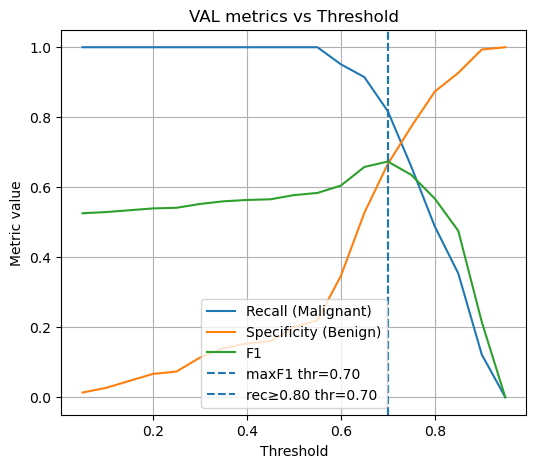

In [ ]:
# ============================
# Cell 9 — Threshold tuning (VAL) + final TEST evaluation
# Works for BCE (1-logit) or CE (2-logit) models
# ============================

# Clinical target for malignant recall; tune this to your use-case/report.
TARGET_REC = 0.80  # e.g., 0.80 or 0.85

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # ensure eval mode (BatchNorm/Dropout frozen)

@torch.no_grad()
def _batch_probs(outputs):
    """
    Convert model raw outputs to P(class=malignant) in a head-agnostic way:
      - BCE (1 logit): sigmoid(logit)
      - CE  (2 logits): softmax(...)[ :, 1]
    """
    if outputs.shape[-1] == 1:                    # BCE (single logit)
        probs = torch.sigmoid(outputs).squeeze(1)
    else:                                         # CE (2 logits)
        probs = torch.softmax(outputs, dim=1)[:, 1]
    return probs

@torch.no_grad()
def collect_probs_targets(loader):
    """
    Forward pass over loader, return concatenated probabilities and targets.
    Uses AMP to speed up on GPU; safe no-op on CPU.
    """
    probs_list, t_list = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            out = model(xb)
        probs = _batch_probs(out).float().cpu().numpy()
        probs_list.append(probs)
        t_list.append(yb.float().cpu().numpy())
    probs = np.concatenate(probs_list)
    targets = np.concatenate(t_list)
    return probs, targets

def metrics_at_threshold(probs, targets, thr):
    """
    Compute standard metrics at a fixed threshold (thr).
    We report specificity explicitly (TN / (TN+FP)), which clinicians care about.
    """
    preds = (probs >= thr).astype(np.int64)
    acc  = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec  = recall_score(targets, preds, zero_division=0)  # malignant sensitivity
    f1   = f1_score(targets, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0, 1]).ravel()
    spec = tn / (tn + fp + 1e-9)
    return {"thr": thr, "acc": acc, "prec": prec, "rec": rec, "spec": spec, "f1": f1,
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn)}

# ---------- 1) Tune on VALIDATION ----------
val_probs, val_targets = collect_probs_targets(val_loader)
try:
    val_auc = roc_auc_score(val_targets, val_probs)  # probability-based AUC
except ValueError:
    val_auc = float("nan")
print(f"VAL AUC (prob-based): {val_auc:.4f}")

# Sweep thresholds (0.05..0.95). You can densify if curves look jagged.
ths = np.linspace(0.05, 0.95, 19)
rows = [metrics_at_threshold(val_probs, val_targets, t) for t in ths]

# Best academic operating point (balanced): max F1
best_f1_row = max(rows, key=lambda r: r["f1"])

# Clinical operating point: meet TARGET_REC, then maximize specificity (tie-breaker by F1)
candidates = [r for r in rows if r["rec"] >= TARGET_REC]
if candidates:
    rec_pref_row = max(candidates, key=lambda r: (r["spec"], r["f1"]))
else:
    # If unattainable, fall back to the highest recall point (report limitation in paper)
    rec_pref_row = max(rows, key=lambda r: r["rec"])

print("\nTop 5 thresholds by F1 on VAL:")
for r in sorted(rows, key=lambda x: x["f1"], reverse=True)[:5]:
    print(f" thr={r['thr']:.2f} | F1={r['f1']:.3f} Rec={r['rec']:.3f} Spec={r['spec']:.3f} Acc={r['acc']:.3f} "
          f"| TP={r['tp']} FP={r['fp']} TN={r['tn']} FN={r['fn']}")

print(f"\nChosen (max F1): thr={best_f1_row['thr']:.2f} | "
      f"F1={best_f1_row['f1']:.3f} Rec={best_f1_row['rec']:.3f} Spec={best_f1_row['spec']:.3f}")
print(f"Chosen (Rec≥{TARGET_REC:.2f} pref): thr={rec_pref_row['thr']:.2f} | "
      f"F1={rec_pref_row['f1']:.3f} Rec={rec_pref_row['rec']:.3f} Spec={rec_pref_row['spec']:.3f}")

# ---------- 2) One-shot EVALUATION on TEST ----------
test_probs, test_targets = collect_probs_targets(test_loader)
try:
    test_auc = roc_auc_score(test_targets, test_probs)
except ValueError:
    test_auc = float("nan")
print(f"\nTEST AUC (prob-based): {test_auc:.4f}")

def eval_on_test(thr, tag):
    r = metrics_at_threshold(test_probs, test_targets, thr)
    print(f"TEST @{tag} thr={thr:.2f} → "
          f"A:{r['acc']:.3f} F1:{r['f1']:.3f} Rec:{r['rec']:.3f} Spec:{r['spec']:.3f} "
          f"| TP={r['tp']} FP={r['fp']} TN={r['tn']} FN={r['fn']}")
    return r

r_f1  = eval_on_test(best_f1_row["thr"], "maxF1")
r_rec = eval_on_test(rec_pref_row["thr"], f"rec≥{TARGET_REC:.2f}")

# ---------- 3) (Optional) Visualize VAL trade-offs ----------
vals = sorted(rows, key=lambda r: r["thr"])
thr_list  = [r["thr"] for r in vals]
rec_list  = [r["rec"] for r in vals]
spec_list = [r["spec"] for r in vals]
f1_list   = [r["f1"] for r in vals]

plt.figure(figsize=(6, 5))
plt.plot(thr_list, rec_list, label="Recall (Malignant)")
plt.plot(thr_list, spec_list, label="Specificity (Benign)")
plt.plot(thr_list, f1_list, label="F1")
plt.axvline(best_f1_row["thr"], ls="--", label=f"maxF1 thr={best_f1_row['thr']:.2f}")
plt.axvline(rec_pref_row["thr"], ls="--", label=f"rec≥{TARGET_REC:.2f} thr={rec_pref_row['thr']:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Metric value"); plt.title("VAL metrics vs Threshold")
plt.grid(True); plt.legend(); plt.show()


Using decision threshold: 0.70
Classification Report:

              precision    recall  f1-score   support

      Benign       0.84      0.68      0.75       151
   Malignant       0.56      0.77      0.65        81

    accuracy                           0.71       232
   macro avg       0.70      0.72      0.70       232
weighted avg       0.74      0.71      0.71       232

Accuracy     : 0.7069
Precision    : 0.5586
Sensitivity  : 0.7654
Specificity  : 0.6755
F1 Score     : 0.6458
ROC AUC      : 0.7739


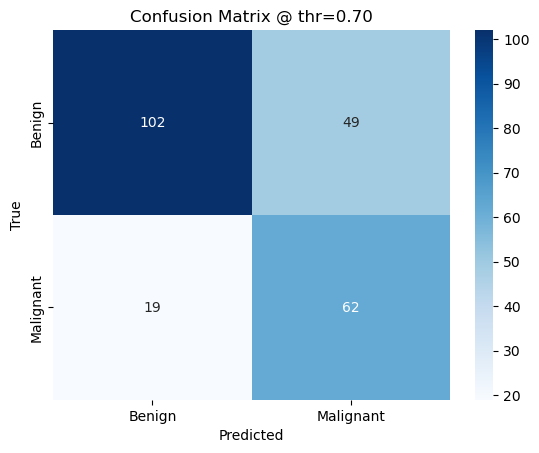

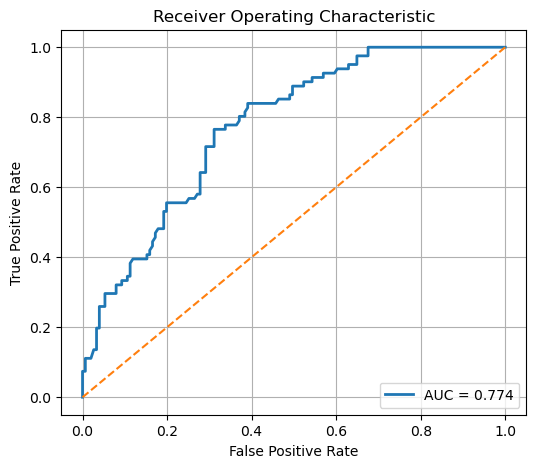

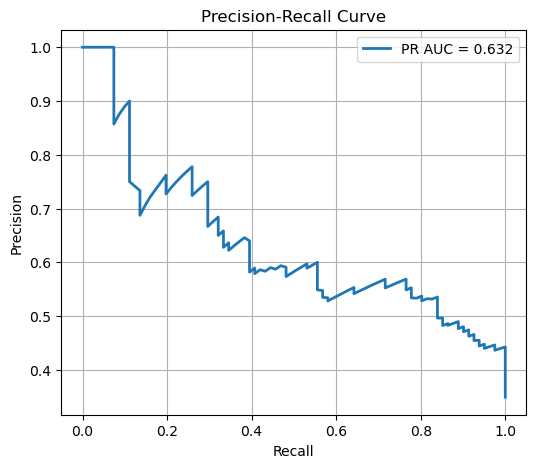

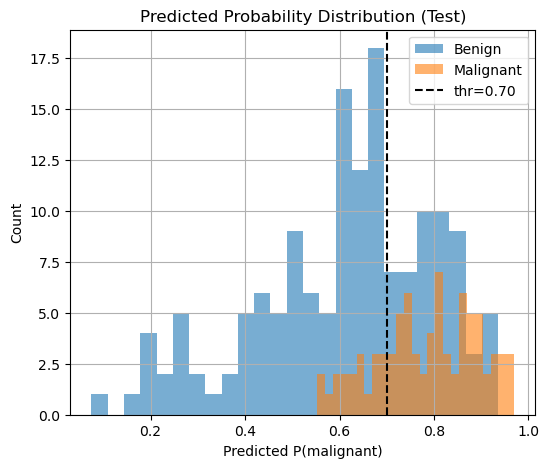

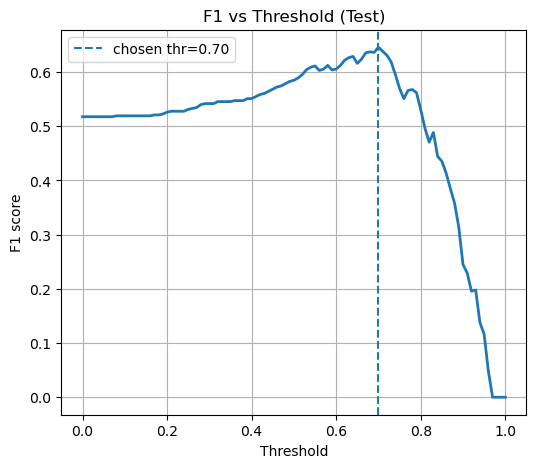


(Checkpoint) Best-on-VAL (as saved):
AUC=0.8165 F1=0.577 Rec=1.000 Spec=0.200 Acc=0.483 @thr=0.50 | TP=82 FP=120 TN=30 FN=0


In [ ]:
# ============================
# Test-time evaluation & plots (robust loader; BCE 1-logit or CE 2-logit)
# ============================

BEST_PATH = globals().get("BEST_PATH", "best_resnet50_bce.pth")

# ---- Load checkpoint: supports pure state_dict OR full checkpoint dict; torch 2.6+ or older ----
ckpt = None
state_dict = None
try:
    obj = torch.load(BEST_PATH, map_location=device, weights_only=True)  # torch>=2.6
except TypeError:
    obj = torch.load(BEST_PATH, map_location=device)                     # torch<2.6

if isinstance(obj, dict) and "state_dict" in obj:
    ckpt = obj
    state_dict = obj["state_dict"]
elif isinstance(obj, dict):
    # Could already be a raw state_dict
    state_dict = obj
else:
    state_dict = obj  # fallback

if state_dict is None or not isinstance(state_dict, dict):
    raise RuntimeError(f"Could not extract a state_dict from {BEST_PATH}")

model.load_state_dict(state_dict)
model.eval()

# ---- Helpers: outputs -> P(malignant), and batched collection ----
@torch.no_grad()
def _batch_probs(outputs: torch.Tensor) -> torch.Tensor:
    # Accepts (N,), (N,1), or (N,2)
    if outputs.dim() == 1:
        return torch.sigmoid(outputs)
    if outputs.shape[-1] == 1:   # BCE head
        return torch.sigmoid(outputs.squeeze(1))
    # CE head (2 logits)
    return torch.softmax(outputs, dim=1)[:, 1]

@torch.no_grad()
def collect_probs_targets(loader):
    probs_list, targets_list = [], []
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).float()
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            outputs = model(images)
        probs = _batch_probs(outputs).float().cpu().numpy()
        probs_list.append(probs)
        targets_list.append(labels.cpu().numpy())
    probs = np.concatenate(probs_list) if probs_list else np.array([])
    targets = np.concatenate(targets_list).astype(int) if targets_list else np.array([], dtype=int)
    return probs, targets

# ---- Collect TEST probs/targets ----
y_prob, y_true = collect_probs_targets(test_loader)
if y_prob.size == 0:
    raise RuntimeError("No test predictions collected. Check test_loader and dataset paths.")

# ---- Choose threshold: clinical > maxF1 > default 0.50 ----
if "CHOSEN_THR_REC" in globals() and isinstance(CHOSEN_THR_REC, (float, int)):
    chosen_thr = float(CHOSEN_THR_REC)
elif "CHOSEN_THR_MAXF1" in globals() and isinstance(CHOSEN_THR_MAXF1, (float, int)):
    chosen_thr = float(CHOSEN_THR_MAXF1)
else:
    chosen_thr = 0.50

print(f"Using decision threshold: {chosen_thr:.2f}")
y_pred = (y_prob >= chosen_thr).astype(int)

# ---- Metrics ----
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)   # sensitivity
f1        = f1_score(y_true, y_pred, zero_division=0)
try:
    roc_auc = roc_auc_score(y_true, y_prob)
except ValueError:
    roc_auc = float("nan")

tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
specificity = tn / (tn + fp + 1e-9)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"], zero_division=0))
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Sensitivity  : {recall:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC      : {roc_auc:.4f}")

# ---- Plots ----
# (a) Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title(f"Confusion Matrix @ thr={chosen_thr:.2f}")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# (b) ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.grid(True); plt.legend(loc="lower right"); plt.show()

# (c) Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
prec_vals, rec_vals, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(rec_vals, prec_vals)
plt.figure(figsize=(6,5))
plt.plot(rec_vals, prec_vals, lw=2, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True); plt.legend(); plt.show()

# (d) Probability Distribution Histogram
plt.figure(figsize=(6,5))
plt.hist(y_prob[y_true == 0], bins=25, alpha=0.6, label="Benign")
plt.hist(y_prob[y_true == 1], bins=25, alpha=0.6, label="Malignant")
plt.axvline(chosen_thr, color='k', linestyle='--', label=f"thr={chosen_thr:.2f}")
plt.xlabel("Predicted P(malignant)"); plt.ylabel("Count")
plt.title("Predicted Probability Distribution (Test)")
plt.legend(); plt.grid(True); plt.show()

# (e) F1 vs Threshold (on Test)
thr_grid = np.linspace(0.0, 1.0, 101)
f1_scores = [f1_score(y_true, (y_prob >= t).astype(int), zero_division=0) for t in thr_grid]
plt.figure(figsize=(6,5))
plt.plot(thr_grid, f1_scores, lw=2)
plt.axvline(chosen_thr, ls='--', label=f"chosen thr={chosen_thr:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 score")
plt.title("F1 vs Threshold (Test)")
plt.grid(True); plt.legend(); plt.show()

# (Optional) If your checkpoint had saved VAL metrics, print them to compare to TEST
if ckpt is not None and isinstance(ckpt, dict) and "val_metrics" in ckpt:
    vm = ckpt["val_metrics"]
    print("\n(Checkpoint) Best-on-VAL (as saved):")
    print(f"AUC={vm.get('auc', float('nan')):.4f} F1={vm.get('f1', float('nan')):.3f} "
          f"Rec={vm.get('rec', float('nan')):.3f} Spec={vm.get('spec', float('nan')):.3f} "
          f"Acc={vm.get('acc', float('nan')):.3f} @thr={vm.get('thr', 0.5):.2f} "
          f"| TP={vm.get('tp','?')} FP={vm.get('fp','?')} TN={vm.get('tn','?')} FN={vm.get('fn','?')}")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image file path     1545 non-null   object
 1   image_path          1545 non-null   object
 2   mask_path           1545 non-null   object
 3   cropped_image_path  1545 non-null   object
 4   label               1545 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 60.5+ KB
